# Estimating the SCC using CIL damage functions and the FAIR SCM

The experiment is conducted as follows:

* Use the RCP scenarios as defined by the default FAIR model
* Add an additional CO2 impulse (1 Gt C) to each trajectory in 2020 (updated from 2015)
* Compute damages using the resulting temperature trajectories
* Subtract the damages in the standard RCPs from the damages in the pulse runs
* Divide this value by the quantity of added CO2 (1 Gt C * 44.0098 / 12.011 = 3.66 Gt CO2) to achieve \$/ton CO2
* Compute the NPV of this time series of marginal damages using various discount rates

Note: Damage function units fed into this calculation should be billions of 2019 USD

## Set up workspace

In [ ]:
# Change this input file to your DB root!
DB = '/mnt/CIL_energy/code_release_data_pixel_interaction'
root =  "/home/liruixue/repos/energy-code-release-2020"

# Scenario options
model = 'main' # options are 'main', 'lininter', and 'lininter_double'
ssp = '3' # 2,3 or 4.Must by 3 if you are not running the main model 
hold_2100_damages_fixed = False # False or True 

# Toggle to generate plots or not
generate_plots = True

In [2]:
%matplotlib inline

In [3]:
# SSP must be "3" unless you are running the main model, in which case it can be 
# also 2 or 4. This is just due to the scenarios we choose to put in the paper. 

if model == 'lininter' or model == 'lininter_double':
    assert ssp == '3',"ssp must be 3 unless you are running the main model"


In [4]:
! pip install fair==1.3.2

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import os, glob

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)

from datetime import datetime

import sys
sys.path.append('./functions/.')
import load_fair

ImportError: No module named load_fair

In [ ]:
# Assign price scenarios to run with

if ssp == '3':
    if model == 'lininter' or model == 'lininter_double':
        # For lininter model:, or lininter_double model 
        scenario_to_run = 'price014' 
    else:
        # For main model
        scenario_to_run = 'price014', 'price0', 'price03', 'WITCHGLOBIOM42', 'MERGEETL60', 'REMINDMAgPIE1730', 'REMIND17CEMICS', 'REMIND17'
else:
    scenario_to_run = 'price014' 

    
if model == 'main':
    model_tag = ''
else:
    model_tag = '_{}'.format(model)
    
# run/code specifications
version = 'v0.5' # code version
specification = 'energy_SSP{}_all_prices'.format(ssp)
stem = 'df_mean_output_SSP{}{}'.format(ssp, model_tag) # file stem for df coefficients
MAGNITUDE_OF_DAMAGES = 1e9  # magnitude of damage function values

INPUT_path = '{}/projection_system_outputs/damage_function_estimation/coefficients/'.format(DB)
OUTPUT_path = '{}/figures/scc_values/{}/'.format(root, model)

# Load FAIR Temperatures Anomaly

## RCPs
We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios. To use the emissions-based version specify ```useMultigas=True``` in the call to ```fair_scm()```.

By default in multi-gas mode, volcanic and solar forcing plus natural emissions of methane and nitrous oxide are switched on.

## SCC

We can compute the SCC by adding an additional pulse in CO2 emissions to the RCP trajectory. 

### Scenario design
This study uses a 1 Gt C emissions pulse. You can change the pulse amount by modifying the PULSE_AMT variable below, and adapting the CONVERSION value to match.

In [ ]:
PULSE_YEAR = 2020  # year in which pulse will be emitted
PULSE_AMT = 1.0  # in Gt C = 1e9 ton C

# CONVERSION is in units of [pulse/tCO2] = [1 pulse/PULSE_AMT GtC * 1 GtC/1e9 tC * 12tC/44tCO2]
# This is used to convert costs ($Bn / pulse) to SCC ($/ton CO2), but the $Bn to $ conversion is separate.
# Therefore, it should be the inverse of any changes to PULSE_AMT
CONVERSION = 1.0 / PULSE_AMT / 1e9 * 12.011 / 44.0098

In [ ]:
fair_temperatures_anomaly = load_fair.temperatures_anomaly(PULSE_YEAR = PULSE_YEAR, 
                                                           PULSE_AMT = PULSE_AMT, 
                                                           make_plots = False, 
                                                           output = OUTPUT_path)

In [ ]:
fair_temperatures_anomaly.sel(pulse = 'pulse',rcp = 'rcp45', year = 2050.0)

In [ ]:
fair_temperatures_anomaly

## Incorporate a single damage function

This is the damage function from Tamma, with a set of coefficients for each year.

Version 0.3 update: The damage function can now be held constant or allowed to vary post-2100. Additionally, different valuation scenarios can be selected within the damage function .csv file. See comments in the document header. 

Note: damages are estimated in Billion 2005 \$PPP, so use the U.S. GDP deflator for 2005 from the World Bank. Take the ratio with the `PULSE_YEAR` deflator (U.S. GDP deflator for the pulse_year from the World Bank) to convert the dollars from 2005 \$PPP to `PULSE_YEAR` $PPP. Update - in version 0.5, the damages are input as billions of 2019 dollars, so these conversion factors are just set to one. 

In [ ]:
# Time the SCC calculation
startTime = datetime.now()

# Make sure the 'year', 'placeholder' and 'growth_rate' columns are the first three columns in the damage function .csv
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))

def read_damage_func(fp):
    df = pd.read_csv(fp, index_col=[0,1,2])
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ss = len(stem) + 1
ee = ss + 4

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})

In [ ]:
ds

In [ ]:
# The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it. (if its in there, change this)
coeffs_all_years = (
    ds.sel(placeholder='ss')
    .to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray()
)

# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)

In [ ]:
coeffs_all_years = coeffs_all_years.sel(variable=stem)

In [ ]:
# debugging
df = coeffs_all_years.to_dataframe().reset_index()
df = df[df.growth_rate == "price014"]


In [ ]:
df[df.year < 2105]

In [ ]:
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = len(coeffs_all_years.growth_rate)
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    for vi, v in enumerate(coeffs_all_years.growth_rate.values):

        lines = []
        for y in reversed(coeffs_all_years.year.values[:86:5]):

            lines.append(
                axes[vi//2, vi%2].plot(
                    temps.values,
                    spaghetti.sel(year=y, growth_rate=v).values,
                    color=matplotlib.cm.Blues_r((y-2020.0)/(2100-2000)),
                    label=int(y)))

        axes[vi//2, vi%2].set_facecolor('white')
        axes[vi//2, vi%2].set_title(v)

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::5],
        labels=list(reversed(coeffs_all_years.year.values[:86]))[::5],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    

### Compute damages

Combine the damage function coefficients with the FAIR temperatures:

$$d_y = c_2*T_y^2+C_1*T_y+C_0 \hspace{1in}\forall \hspace{0.1in} y \in [2020, 2300]$$

In [ ]:
damages = (
    (coeffs_all_years.to_array('coeff') * (fair_temperatures_anomaly ** powers)).sum(dim='coeff'))

In [ ]:
damages.pulse.values

### Plot time series of damages

In [ ]:
if generate_plots:
    numvars = len(coeffs_all_years.growth_rate)
    fig, ax = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        ax = np.array([[ax]])

    colors = ['green', 'blue', 'red', 'black']
    styles = ['solid', 'dashed']

    lines = []
    labels = []
    for g, gr in enumerate(damages.growth_rate.values):
        for r, rcp in enumerate(damages.rcp.values):
            for p, pulse in enumerate(damages.pulse.values):
                if(g==0):
                    labels.append('{}{}'.format(rcp, ['', '+'][p]))
                lines.append(
                    ax[g//2, g%2].plot(
                        damages.year,
                        damages.sel(growth_rate=gr, rcp=rcp, pulse=pulse),
                        color=colors[r],
                        linestyle=styles[p])[0])
        
        ax[g//2, g%2].set_title('Time series of damages by scenario (Billion USD2019):\n{}'.format(gr))
        ax[g//2, g%2].legend(lines, labels)

    sns.despine()    

### Plot time series of damages incurred due to pulse

In [ ]:
if generate_plots:
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (damages.sel(growth_rate=var) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Time series of damages incurred due to pulse (2019USD / ton CO2)\n{}'.format(var),
            size=11)

    sns.despine()
    plt.tight_layout()


### Compue the SCC (NPV of damages)

discount the time series of damages using the formula

$$SCC=\sum_{y\in\left[2020, 2300\right]}{\frac{d_y}{\left({1+r}\right)^{y-2020}}}$$

### Plot the current equivalent damage time series

In [ ]:
discrates = [1.,2.,2.5, 3., 5.]

discdata = []
for r in discrates:
    discdata.append(damages / (1+r/100)**(damages.year - 2020)) #updated in version 0.5 to 2020

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

rcp = 'rcp85'
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (current_equivalent_damages.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
            size=11)

    sns.despine()
    plt.tight_layout()
#

In [6]:
# WIP: update figure 4 panel D
discrates = [2.]

discdata = []
for r in discrates:
    discdata.append(damages / (1+r/100)**(damages.year - 2020)) #updated in version 0.5 to 2020

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

rcp = 'rcp45'
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (current_equivalent_damages.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
            size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/figures/SSP{}_fixed_{}_current_equivalent_damages_rcp45.pdf'.format(root,ssp,hold_2100_damages_fixed))


NameError: name 'damages' is not defined

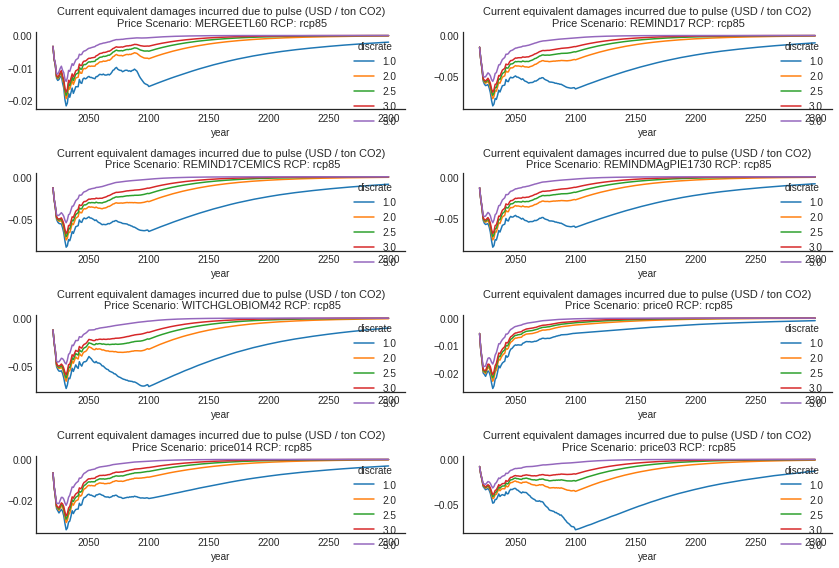

In [104]:
discrates = [1.,2.,2.5, 3., 5.]

discdata = []
for r in discrates:
    discdata.append(damages / (1+r/100)**(damages.year - 2020)) #updated in version 0.5 to 2020

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

rcp = 'rcp85'
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (current_equivalent_damages.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
            size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/figures/SSP{}_fixed_current_equivalent_damages_rcp85.pdf'.format(root,ssp,hold_2100_damages_fixed))



### Plot SCC (sum of discounted marginal damage time series) by discount rate and RCP

In [105]:
scc = (
    (current_equivalent_damages.diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_pre_2100 = (
    (current_equivalent_damages.sel(year=slice(2020, 2099)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_post_2100 = (
    (current_equivalent_damages.sel(year=slice(2100, 3000)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_share_post2100 = (
    scc_post_2100 / scc)

scc = xr.concat([scc, scc_pre_2100, scc_post_2100, scc_share_post2100], pd.Index(['all', 'pre2100', 'post2100', 'share_post2100'], name='time_cut'))


### Export SCC to CSV

In [106]:
 (
    scc
    .to_series()
    .unstack('rcp')
    .to_csv('{}/scc_{}_2100-fixed-{}.csv'.format(OUTPUT_path, specification, hold_2100_damages_fixed)))

In [107]:
'{}/scc_{}_2100-fixed-{}.csv'.format(OUTPUT_path, specification, hold_2100_damages_fixed)

'/home/liruixue/repos/energy-code-release-2020/figures/scc_values/main//scc_energy_SSP3_all_prices_2100-fixed-True.csv'

In [108]:
# Print the output to the notebook, so we can take a look in the browser.
scc.to_series().unstack('rcp')

rcp                                           rcp26      rcp45      rcp60  \
time_cut       discrate growth_rate                                         
all            1.0      MERGEETL60        -2.617605  -2.665025  -2.642619   
                        REMIND17         -10.535814 -11.057141 -11.112661   
                        REMIND17CEMICS   -10.412527 -10.891213 -10.923774   
                        REMINDMAgPIE1730 -10.050860 -10.516210 -10.593011   
                        WITCHGLOBIOM42    -9.840042 -10.800648 -11.003471   
                        price0            -1.287762  -1.374276  -1.438688   
                        price014          -2.836104  -3.215675  -3.416629   
                        price03           -8.157346  -9.854387 -10.638637   
               2.0      MERGEETL60        -1.218143  -1.191763  -1.181238   
                        REMIND17          -4.974698  -4.992116  -4.983465   
                        REMIND17CEMICS    -4.868081  -4.875094  -4.863392   
                        REMINDMAgPIE1730  -4.799779  -4.788788  -4.794753   
                        WITCHGLOBIOM42    -4.445480  -4.644502  -4.662561   
                        price0            -0.832801  -0.829178  -0.847433   
                        price014          -1.555882  -1.606762  -1.653300   
                        price03           -3.696649  -4.028720  -4.195368   
               2.5      MERGEETL60        -0.928999  -0.898320  -0.892228   
                        REMIND17          -3.808019  -3.769795  -3.762068   
                        REMIND17CEMICS    -3.710759  -3.666564  -3.658411   
                        REMINDMAgPIE1730  -3.690700  -3.629325  -3.633882   
                        WITCHGLOBIOM42    -3.339799  -3.433436  -3.435420   
                        price0            -0.711623  -0.697937  -0.709802   
                        price014          -1.255924  -1.264467  -1.290443   
                        price03           -2.760813  -2.905483  -2.990465   
               3.0      MERGEETL60        -0.742818  -0.712979  -0.709907   
                        REMIND17          -3.051453  -2.993329  -2.989098   
                        REMIND17CEMICS    -2.962635  -2.900691  -2.897209   
                        REMINDMAgPIE1730  -2.968202  -2.890406  -2.896664   
                        WITCHGLOBIOM42    -2.635152  -2.677490  -2.674832   
                        price0            -0.621904  -0.604747  -0.613362   
...                                             ...        ...        ...   
share_post2100 2.0      REMIND17CEMICS     0.284554   0.314490   0.315640   
                        REMINDMAgPIE1730   0.269451   0.301867   0.303600   
                        WITCHGLOBIOM42     0.309148   0.342903   0.351003   
                        price0             0.091290   0.127832   0.140365   
                        price014           0.173713   0.231903   0.251734   
                        price03            0.298976   0.376163   0.402544   
               2.5      MERGEETL60         0.210374   0.232778   0.229906   
                        REMIND17           0.198696   0.222293   0.223068   
                        REMIND17CEMICS     0.204580   0.227754   0.227680   
                        REMINDMAgPIE1730   0.192060   0.216900   0.217282   
                        WITCHGLOBIOM42     0.225614   0.252406   0.258064   
                        price0             0.058696   0.082355   0.090303   
                        price014           0.118217   0.159828   0.173839   
                        price03            0.219895   0.282922   0.304436   
               3.0      MERGEETL60         0.149461   0.165912   0.163048   
                        REMIND17           0.140895   0.158273   0.158243   
                        REMIND17CEMICS     0.145593   0.162777   0.162081   
                        REMINDMAgPIE1730   0.135699   0.153966   0.153625   
                        WITCHGLOBIOM42     0.162527   0.182868   0.186602